<a href="https://colab.research.google.com/github/hcnancho/lickan_ventas_2023/blob/main/Lickan_Deep_2022_RNN_df_al_gato_rev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploracion de Datos LickanPets

*   Importación de las Librerias
*   Conexión con Google Drive

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.constraints import nonneg

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_lickan = pd.read_excel('/content/drive/MyDrive/Proyecto_Deep_Lickan2022/bd_lickan_ventas_2016_oct_01_2022.xlsx')

##Extraccion del dataframe Alimento de Gato

In [4]:
df_lickan.shape

(78828, 30)

Descripción incial de datos y revision de valores nulos

### Copiamos la data, para mantener los datos originales sin alteración, en el caso que los necesitemos revisar nuevamente

In [5]:
df_lmod = df_lickan.copy() 

### Quitamos las columnas que parecieran redundante para la primera etapa del analisis

In [6]:
df_lmod = df_lmod.drop(columns=['Email Cliente','Ciudad Cliente','Comuna Cliente','Dirección Cliente','Detalle de Productos/Servicios Pack/Promo','Margen','Cliente','Tipo Movimiento', 'Vendedor', 'Tipo de Documento', 'Rut Cliente', 'Tracking Number','Lista de Precio', 'Fecha Documento', 'Precio Neto Unitario', 'Subtotal Impuestos', 'Subtotal Neto', 'Costo Neto Unitario', 'Costo Total Neto', '% Margen','Otros Atributos'])

revisamos que valores siguen siendo nulos para el dataframe reducido y los eliminamos

In [7]:
null_columns=df_lmod.columns[df_lmod.isnull().any()]
df_lmod[null_columns].isnull().sum()
print(df_lmod[df_lmod.isnull().any(axis=1)][null_columns].head())
df_lmod = df_lmod.dropna(how='any')

      Sucursal  Numero Documento Fecha Venta Hora Venta  \
78827      NaN               NaN         NaN        NaN   

      Tipo de Producto / Servicio  SKU Producto / Servicio  Cantidad  
78827                         NaN  NaN                 NaN       NaN  


In [8]:
df_lmod.isnull().sum()

Sucursal                       0
Numero Documento               0
Fecha Venta                    0
Hora Venta                     0
Tipo de Producto / Servicio    0
SKU                            0
Producto / Servicio            0
Cantidad                       0
Subtotal Bruto                 0
dtype: int64

In [9]:
df_lmod.shape

(78827, 9)

### Cambiamos el encabezado de las colummas para hacer mas simple la interpretación de los datos

In [10]:
df_lmod = df_lmod.rename(columns={'Tipo de Producto / Servicio':'Familia_Producto_Servicio',
                                   'Producto / Servicio':'Producto_Servicio', 'Fecha Venta':'Fecha_Venta', 'Hora Venta':'Hora_Venta' })

Agrupasmos el Dataframe por Familia de productos, ya que este nos permitira identificar cual es la que más aporta a los ingresos del negocio. Las Familias son : Alimento, Peluquería, Veterinaria, Farmacia, Ladrería y Pet Shop

In [11]:
#hacemos una copia de la data, asegurando que los datos que tome sean mayo que 0 en las ventas
df_lmod_FPS = df_lmod.copy()
df_lmod_FPS = df_lmod_FPS[(df_lmod_FPS['Subtotal Bruto'] > 0)]
df_lmod_FPS = df_lmod_FPS.replace({'Accesorio para perro': 'PETS SHOP', "Bowl Dog": 'PETS SHOP', 'Collar':'PETS SHOP', 'CIRUGÍA':'Veterinaria','CIRUGÍA EXTRACCIÓN MASA OCULAR':'Veterinaria','ESTERILIZACIONES Y CASTRACIONES':'Veterinaria','Sin Tipo':'Veterinaria'})
df_lmod_FPS['Familia_Producto_Servicio'].unique()

array(['PETS SHOP', 'ALIMENTO', 'PELUQUERÍA', 'Veterinaria', 'FARMACIA',
       'LADRERÍA', 'Cuidados Pets'], dtype=object)

##Construeccion de la Familia Alimentos (Alimento, Alimento Perro y Alimento Gato)

In [12]:
#hacemos una copia de la data que contenga solo alimentos, asegurando que los datos que tome sean mayo que 0 en las ventas

df_lmod_Al = df_lmod_FPS[(df_lmod_FPS.Familia_Producto_Servicio == 'ALIMENTO')&(df_lmod_FPS['Subtotal Bruto'] > 0)]
df_lmod_Al.head()

,Sucursal,Numero Documento,Fecha_Venta,Hora_Venta,Familia_Producto_Servicio,SKU,Producto_Servicio,Cantidad,Subtotal Bruto
4,Casa Matriz,3.0,16/12/2016,10:52 AM,ALIMENTO,12295045,PRO PLAN DOG DELICATE SMALL BREED 3KG,1.0,14681
7,Casa Matriz,5.0,16/12/2016,01:18 PM,ALIMENTO,12294992,PRO PLAN DOG EXIGENT SM BR 3KG,1.0,14681
13,Casa Matriz,10.0,16/12/2016,07:52 PM,ALIMENTO,12294283,PRO PLAN CAT ADULT CAT 3 KGS,1.0,15947
19,Casa Matriz,14.0,17/12/2016,09:19 AM,ALIMENTO,12294993,PRO PLAN DOG PUPPY SMALL BREED 3 KG,1.0,14319
37,Casa Matriz,23.0,17/12/2016,03:54 PM,ALIMENTO,12294293,PRO PLAN CAT CAT KITTEN 1KG,1.0,6436


In [13]:
df_lmod_Al.Familia_Producto_Servicio.unique()

array(['ALIMENTO'], dtype=object)

Ordenamos las fechas, dentro de la data

In [14]:
import datetime
df_lmod_Al['Fecha_Venta']= pd.to_datetime(df_lmod_Al['Fecha_Venta']) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
df_lmod_Al_sort=df_lmod_Al.sort_values(by=['Fecha_Venta'])

In [16]:
df_lmod_Al_sort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25861 entries, 4 to 78058
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Sucursal                   25861 non-null  object        
 1   Numero Documento           25861 non-null  float64       
 2   Fecha_Venta                25861 non-null  datetime64[ns]
 3   Hora_Venta                 25861 non-null  object        
 4   Familia_Producto_Servicio  25861 non-null  object        
 5   SKU                        25861 non-null  object        
 6   Producto_Servicio          25861 non-null  object        
 7   Cantidad                   25861 non-null  float64       
 8   Subtotal Bruto             25861 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 2.0+ MB


Separamos entre alimentos de gatos y perro, usando palabras claves que se encuentran presentes en los nombres de cada alimento

In [17]:
df_al_perro = df_lmod_Al_sort[(df_lmod_Al_sort.Producto_Servicio.str.contains(' DOG | PERRO | PUPPY | CACHORRO | PEDIGREE | Excellent | CACHUPIN | EXCELLENT'))]
df_al_gato = df_lmod_Al_sort[(df_lmod_Al_sort.Producto_Servicio.str.contains(' GATO | CAT | KITTEN | FELINE | GATI '))]

In [18]:
df_al_perro.head()

,Sucursal,Numero Documento,Fecha_Venta,Hora_Venta,Familia_Producto_Servicio,SKU,Producto_Servicio,Cantidad,Subtotal Bruto
4,Casa Matriz,3.0,2016-12-16,10:52 AM,ALIMENTO,12295045,PRO PLAN DOG DELICATE SMALL BREED 3KG,1.0,14681
7,Casa Matriz,5.0,2016-12-16,01:18 PM,ALIMENTO,12294992,PRO PLAN DOG EXIGENT SM BR 3KG,1.0,14681
19,Casa Matriz,14.0,2016-12-17,09:19 AM,ALIMENTO,12294993,PRO PLAN DOG PUPPY SMALL BREED 3 KG,1.0,14319
40,Casa Matriz,24.0,2016-12-17,04:24 PM,ALIMENTO,12294993,PRO PLAN DOG PUPPY SMALL BREED 3 KG,1.0,14319
44,Casa Matriz,28.0,2016-12-17,06:20 PM,ALIMENTO,12294994,PRO PLAN DOG PUPPY SMALL BREED 1 KG,1.0,5428


In [19]:
df_al_perro.describe()

,Numero Documento,Cantidad,Subtotal Bruto
count,10172.000000,10172.000000,10172.000000
mean,30239.984074,1.177645,27091.819308
std,11413.881497,0.785274,18158.315147
min,1.000000,1.000000,1200.000000
25%,24723.750000,1.000000,17990.000000
50%,32291.500000,1.000000,20990.000000
75%,39025.750000,1.000000,36990.000000
max,46012.000000,16.000000,309950.000000


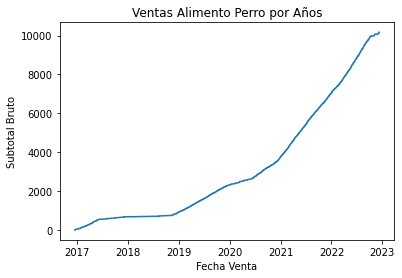

In [20]:
plt.figure()

plt.plot(df_al_perro.Fecha_Venta,np.arange(df_al_perro.Fecha_Venta.shape[0]))
plt.xlabel('Fecha Venta')
plt.ylabel('Subtotal Bruto')
plt.title('Ventas Alimento Perro por Años')
plt.show()

In [21]:
df_al_gato.head()

,Sucursal,Numero Documento,Fecha_Venta,Hora_Venta,Familia_Producto_Servicio,SKU,Producto_Servicio,Cantidad,Subtotal Bruto
13,Casa Matriz,10.0,2016-12-16,07:52 PM,ALIMENTO,12294283,PRO PLAN CAT ADULT CAT 3 KGS,1.0,15947
37,Casa Matriz,23.0,2016-12-17,03:54 PM,ALIMENTO,12294293,PRO PLAN CAT CAT KITTEN 1KG,1.0,6436
113,Casa Matriz,80.0,2016-12-20,10:17 PM,ALIMENTO,12294293,PRO PLAN CAT CAT KITTEN 1KG,1.0,6436
142,Casa Matriz,96.0,2016-12-21,08:39 PM,ALIMENTO,12294293,PRO PLAN CAT CAT KITTEN 1KG,1.0,6436
146,Casa Matriz,99.0,2016-12-22,10:58 AM,ALIMENTO,12294320,PRO PLAN CAT URINARY 3KG,1.0,5951


In [22]:
df_al_gato.describe()

,Numero Documento,Cantidad,Subtotal Bruto
count,4616.000000,4616.000000,4616.000000
mean,29924.360052,1.712088,20645.803943
std,11242.179153,3.939201,15075.249090
min,10.000000,1.000000,700.000000
25%,25638.000000,1.000000,9990.000000
50%,32115.500000,1.000000,17990.000000
75%,37564.000000,1.000000,24990.000000
max,46014.000000,120.000000,180000.000000


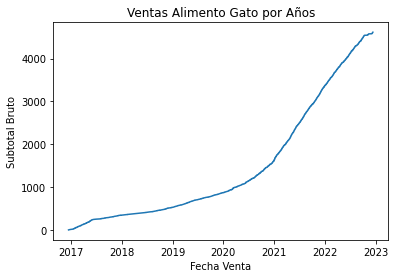

In [23]:
plt.figure()

plt.plot(df_al_gato.Fecha_Venta,np.arange(df_al_gato.Fecha_Venta.shape[0]))
plt.xlabel('Fecha Venta')
plt.ylabel('Subtotal Bruto')
plt.title('Ventas Alimento Gato por Años')
plt.show()

##Construccion del primer modelo
Usaremos un RNN

Vamos a sub dividir el conjunto de entrenamiento en entrenamiento y validación.

In [24]:
df = pd.DataFrame(df_al_gato['Fecha_Venta'])
df = df.assign(Ventas = df_al_gato['Subtotal Bruto'])

df_sort=df.sort_values(by=['Fecha_Venta'])


In [25]:
df_sort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4616 entries, 13 to 78042
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Fecha_Venta  4616 non-null   datetime64[ns]
 1   Ventas       4616 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 108.2 KB


In [26]:
df_sort

,Fecha_Venta,Ventas
13,2016-12-16,15947
37,2016-12-17,6436
113,2016-12-20,6436
142,2016-12-21,6436
146,2016-12-22,5951
...,...,...
78035,2022-12-09,49600
78044,2022-12-09,47990
78049,2022-12-09,17990
78018,2022-12-09,15500


Agrupamos las ventas por día

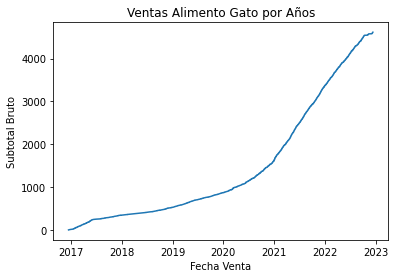

In [29]:
plt.plot(df_sort.Fecha_Venta,np.arange(df_sort.Fecha_Venta.shape[0]))
plt.xlabel('Fecha Venta')
plt.ylabel('Subtotal Bruto')
plt.title('Ventas Alimento Gato por Años')
plt.show()

In [27]:
df_ventas_dia = df_sort.groupby(['Fecha_Venta']).sum()

In [28]:
df_ventas_dia

,Ventas
Fecha_Venta,
2016-12-16,15947
2016-12-17,6436
2016-12-20,6436
2016-12-21,6436
2016-12-22,11902
...,...
2022-12-05,157060
2022-12-06,65970
2022-12-07,129960


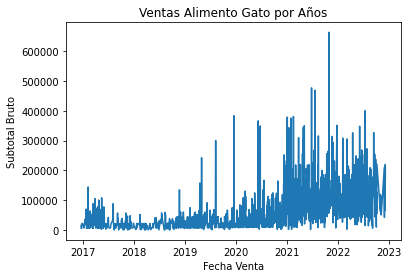

In [30]:
plt.plot(df_ventas_dia)
plt.xlabel('Fecha Venta')
plt.ylabel('Subtotal Bruto')
plt.title('Ventas Alimento Gato por Años')
plt.show()

In [31]:
# Extraemos la columna Ventas para el desarrollo del modelo Deep Learning

df_sort = df_ventas_dia.reset_index()
df_sort.head()

,Fecha_Venta,Ventas
0,2016-12-16,15947
1,2016-12-17,6436
2,2016-12-20,6436
3,2016-12-21,6436
4,2016-12-22,11902


In [51]:
df_sort.shape

(1422, 1)

In [33]:
df_sort = df_sort.drop(columns=['Fecha_Venta'])
df_sort.head()

,Ventas
0,15947
1,6436
2,6436
3,6436
4,11902


In [87]:
dataset = df_sort.values
dataset = dataset.astype('float32')
print('Shape conjunto de datos : {}'.format(dataset.shape))
print('Ejemplo : \n{}'.format(dataset[:3]))

Shape conjunto de datos : (1422, 1)
Ejemplo : 
[[15947.]
 [ 6436.]
 [ 6436.]]


In [88]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

print('Antes de escalar')
print('valor min : {}, valor max : {}'.format(np.amin(dataset), np.amax(dataset)))

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

print('Despues de escalar')
print('valor min : {}, valor max : {}'.format(np.amin(dataset), np.amax(dataset)))

Antes de escalar
valor min : 1036.0, valor max : 662350.0
Despues de escalar
valor min : 0.0, valor max : 1.0000001192092896


In [89]:
#Separamos el dataset en Entrenamiento y Test
split = int(len(dataset) * 0.67)
train, test = dataset[:split,:], dataset[split:,:]
print('Train : {}, Test : {}'.format(train.shape, test.shape)) 

Train : (952, 1), Test : (470, 1)


Reordenar los datos para hacer la predicción

X = t

y = t+1

In [90]:
# Train

look_back = 7
X_train, y_train = [], []

for i in range(len(train)-look_back-1):
  x = train[i:(i+look_back), 0]
  y = train[i+look_back, 0]

  X_train.append(x)
  y_train.append(y)

	
X_train, y_train = np.array(X_train), np.array(y_train)
print('X :{},\nY : {}'.format(X_train[:5], y_train[:5]))

print('\nX shape: {}, y shape: {}'.format(X_train.shape, y_train.shape))

X :[[0.02254754 0.00816556 0.00816556 0.00816556 0.01643092 0.02392207
  0.03365421]
 [0.00816556 0.00816556 0.00816556 0.01643092 0.02392207 0.03365421
  0.02762833]
 [0.00816556 0.00816556 0.01643092 0.02392207 0.03365421 0.02762833
  0.02392207]
 [0.00816556 0.01643092 0.02392207 0.03365421 0.02762833 0.02392207
  0.02693728]
 [0.01643092 0.02392207 0.03365421 0.02762833 0.02392207 0.02693728
  0.01957315]],
Y : [0.02762833 0.02392207 0.02693728 0.01957315 0.00975936]

X shape: (944, 7), y shape: (944,)


In [91]:
# Test
look_back = 7
X_test, y_test = [], []

for i in range(len(test)-look_back-1):
  x = test[i:(i+look_back), 0]
  y = test[i+look_back, 0]

  X_test.append(x)
  y_test.append(y)

	
X_test, y_test = np.array(X_test), np.array(y_test)
print('X :{},\nY : {}'.format(X_test[:5], y_test[:5]))

X :[[0.15865989 0.12360845 0.32792893 0.19339377 0.09424116 0.11406684
  0.17527832]
 [0.12360845 0.32792893 0.19339377 0.09424116 0.11406684 0.17527832
  0.12912777]
 [0.32792893 0.19339377 0.09424116 0.11406684 0.17527832 0.12912777
  0.08456497]
 [0.19339377 0.09424116 0.11406684 0.17527832 0.12912777 0.08456497
  0.27194947]
 [0.09424116 0.11406684 0.17527832 0.12912777 0.08456497 0.27194947
  0.25087023]],
Y : [0.12912777 0.08456497 0.27194947 0.25087023 0.33096835]


Actualmente nuestro conjunto de datos de entrada se encuentra organizados como **[#muestras, dato]**, pero necesitamos que sea **[#muestras, time steps, dato]** para que sea una entrada correcta para la RNN (de acuerdo a la [documentación](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN)).

In [92]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('train : {}, test : {}'.format(X_train.shape, X_test.shape))

train : (944, 1, 7), test : (462, 1, 7)


## Modelo - Simple RNN

In [93]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.constraints import nonneg


model = Sequential()
model.add(SimpleRNN(8, activation='relu',input_shape=(1,look_back), return_sequences=True))
model.add(SimpleRNN(16, activation='relu', return_sequences = True))
model.add(SimpleRNN(32, activation='relu', return_sequences = True))
model.add(SimpleRNN(64, activation='relu', return_sequences = True))
model.add(SimpleRNN(128, activation='relu'))

model.add((Dense(1, activation='linear', kernel_constraint=nonneg())))

print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_26 (SimpleRNN)   (None, 1, 8)              128       
                                                                 
 simple_rnn_27 (SimpleRNN)   (None, 1, 16)             400       
                                                                 
 simple_rnn_28 (SimpleRNN)   (None, 1, 32)             1568      
                                                                 
 simple_rnn_29 (SimpleRNN)   (None, 1, 64)             6208      
                                                                 
 simple_rnn_30 (SimpleRNN)   (None, 128)               24704     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,137
Trainable params: 33,137
Non-tra

Compilar

In [94]:
model.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics = ['mse'])

In [95]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
min_delta=0,
patience=30,
mode='min',
restore_best_weights=True)

Entrenamiento

In [96]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=10000, 
                    batch_size=25, 
                    verbose=2, 
                    validation_split=0.2)

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 7501/10000
31/31 - 0s - loss: 1.6206e-04 - mse: 1.6206e-04 - val_loss: 0.0281 - val_mse: 0.0281 - 187ms/epoch - 6ms/step
Epoch 7502/10000
31/31 - 0s - loss: 1.6114e-04 - mse: 1.6114e-04 - val_loss: 0.0282 - val_mse: 0.0282 - 198ms/epoch - 6ms/step
Epoch 7503/10000
31/31 - 0s - loss: 1.6114e-04 - mse: 1.6114e-04 - val_loss: 0.0282 - val_mse: 0.0282 - 190ms/epoch - 6ms/step
Epoch 7504/10000
31/31 - 0s - loss: 1.6080e-04 - mse: 1.6080e-04 - val_loss: 0.0280 - val_mse: 0.0280 - 206ms/epoch - 7ms/step
Epoch 7505/10000
31/31 - 0s - loss: 1.6068e-04 - mse: 1.6068e-04 - val_loss: 0.0280 - val_mse: 0.0280 - 199ms/epoch - 6ms/step
Epoch 7506/10000
31/31 - 0s - loss: 1.6126e-04 - mse: 1.6126e-04 - val_loss: 0.0283 - val_mse: 0.0283 - 188ms/epoch - 6ms/step
Epoch 7507/10000
31/31 - 0s - loss: 1.6020e-04 - mse: 1.6020e-04 - val_loss: 0.0282 - val_mse: 0.0282 - 182ms/epoch - 6ms/step
Epoch 7508/10000
31/31 - 0s - loss: 1.5985e-04 - m

Curva función Costo

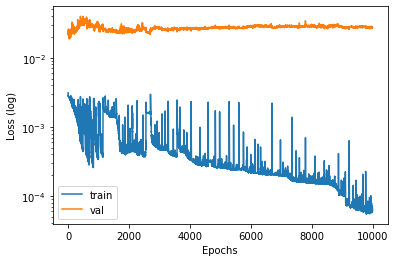

In [97]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss (log)')
plt.yscale('log')
plt.legend()

plt.show()

Predicción

In [98]:
# Obtener predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

15/15 [==============================] - 0s 2ms/step


In [99]:
# Volver a magnitud original
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

Graficar resultados

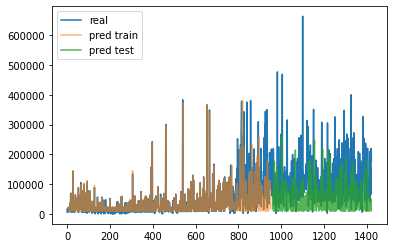

In [100]:
# Creamos un arreglo vacío para acomodar las predicciones de entrenamiento en el rango correcto
train_predict_curve = np.empty_like(dataset)
train_predict_curve[:, :] = np.nan
train_predict_curve[look_back:len(train_predictions)+look_back, :] = train_predictions

# Hacemos lo mismo para las predicciones del conjunto de test y ubicamos las predicciones luego de las predicciones de entrenamiento.
test_predict_curve = np.empty_like(dataset)
test_predict_curve[:, :] = np.nan
test_predict_curve[len(train_predictions)+(look_back*2)+1:len(dataset)-1, :] = test_predictions

# Graficamos
a1, = plt.plot(scaler.inverse_transform(dataset))
a2, = plt.plot(train_predict_curve, alpha=0.6)
a3, = plt.plot(test_predict_curve, alpha=0.8)
plt.legend([a1, a2, a3], ['real','pred train','pred test'])
plt.show()

##La Hipotesis:

**Agosto es el mes historico con mayores ventas en LickanPets**

**Problematica:**

* Definir en base a las ventas historicas, volumen de venta mensual en 2023

* nos gustaria hacer una claseterizacion por familia de producto o por tipo de producto y conocer la proyección de venta.


**Ideas fuezas**

* ¿Cual es el alimento que más se vende y en que momento del mes?

* La segunda semana del mes se vende más alimentos Kitten

* Los perros que consumen PRO PLAN DOG PUPPY SMALL BREED 
 
* La tercera semana de cada mes el producto que más se vende es el PROPLAN GATO KITTEN

* Dividir en cuadrantes y ver tendencia de ventas para comida de perro